In [27]:
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io, color, transform

import cv2
import numpy as np
import os
import pandas as pd
import re

from PIL import Image
from sklearn.preprocessing import MinMaxScaler

# READ DATA

In [28]:
data = pd.read_csv("dataset.csv")

# CHECK CLASS IMBALANCE

In [29]:
class_counts = data['label'].value_counts()
print(class_counts)

label
0    2700
1    2700
2    2700
3    2700
4    2700
Name: count, dtype: int64


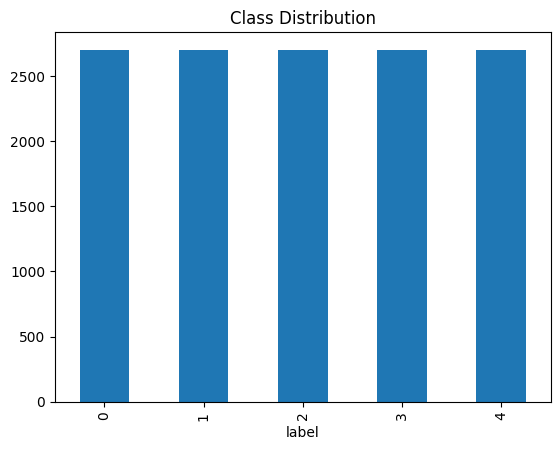

In [30]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cân bằng lớp
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()


In [31]:
total_samples = len(data)
class_ratios = class_counts / total_samples
print(class_ratios)

label
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: count, dtype: float64


# SPLIT DATA

In [32]:
x = data.drop("label", axis=1)
y = data['label']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

In [34]:
X_train[0]

array([0.11752745, 0.15395251, 0.18610086, 0.02501145, 0.05742914,
       0.03776961, 0.01393047, 0.00121678, 0.11672837, 0.15044546,
       0.12449515, 0.30063378, 0.30063378, 0.28613222, 0.18573883,
       0.08762766, 0.05475968, 0.07078443, 0.30063378, 0.30063378,
       0.12222634, 0.02909082, 0.0386255 , 0.03800817, 0.03687454,
       0.00198116, 0.30063378, 0.30063378, 0.30063378, 0.13670308,
       0.0548537 , 0.04608064, 0.08397551, 0.18104719, 0.06243373,
       0.13487596, 0.16108587, 0.1333002 , 0.30425037, 0.30425037,
       0.30425037, 0.1988754 , 0.09382522, 0.05863261, 0.07579074,
       0.10405816, 0.08047851, 0.05891124, 0.06053625, 0.19249688,
       0.09411394, 0.14768709, 0.13436044, 0.19422878, 0.30425037,
       0.30425037, 0.14637155, 0.05873329, 0.04933974, 0.08991477,
       0.19385194, 0.06684942, 0.1444152 , 0.02326672, 0.0193554 ,
       0.04159845, 0.08359527, 0.28991998, 0.30425037, 0.05207871,
       0.0249426 , 0.00869099, 0.11458946, 0.08862342, 0.06487

# SCALE DATA

In [35]:
# Khởi tạo mô hình MinMaxScaler và fit trên tập huấn luyện
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Sử dụng mô hình đã fit để chuẩn hóa tập kiểm tra
X_test_scaled = scaler.transform(X_test)

# TRAIN

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Huấn luyện mô hình Random Forest với các tham số cụ thể
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, max_features='sqrt', min_samples_split=5)
rf_model.fit(X_train_scaled, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = rf_model.predict(X_test_scaled)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5728395061728395


# EVALUATE

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tabulate import tabulate

# Assume y_test and y_pred are already defined

# Calculate precision, recall, and f1-score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

class_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']

# Calculate overall precision, recall, and f1-score
overall_precision = precision.mean()
overall_recall = recall.mean()
overall_f1 = f1.mean()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Create the table
table = []
for i in range(len(class_names)):
    table.append([class_names[i], f"{precision[i]:.4f}", f"{recall[i]:.4f}", f"{f1[i]:.4f}"])
table.append(["Overall", f"{overall_precision:.4f}", f"{overall_recall:.4f}", f"{overall_f1:.4f}"])

# Print the table
print(tabulate(table, headers=["Class", "Precision", "Recall", "F1-Score"], tablefmt="grid"))

# Print accuracy
print(f"\nAccuracy: {accuracy:.4f}")

+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-Score |
+=========+=============+==========+============+
| Angry   |      0.5387 |   0.5706 |     0.5542 |
+---------+-------------+----------+------------+
| Fear    |      0.5466 |   0.5168 |     0.5313 |
+---------+-------------+----------+------------+
| Happy   |      0.6776 |   0.7765 |     0.7237 |
+---------+-------------+----------+------------+
| Neutral |      0.6143 |   0.6061 |     0.6102 |
+---------+-------------+----------+------------+
| Sad     |      0.4561 |   0.3925 |     0.4219 |
+---------+-------------+----------+------------+
| Overall |      0.5667 |   0.5725 |     0.5683 |
+---------+-------------+----------+------------+

Accuracy: 0.5728


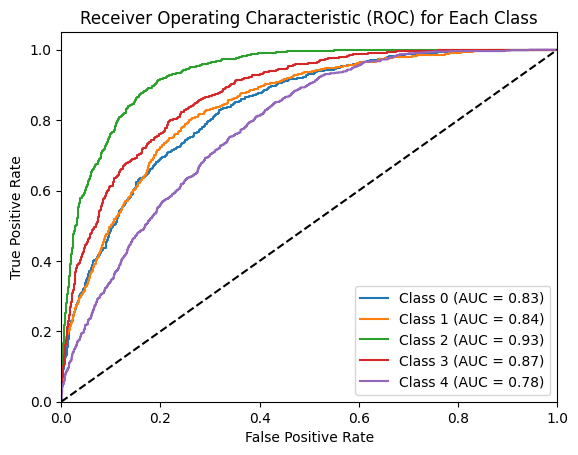

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Compute predicted probabilities for each class
y_prob = rf_model.predict_proba(X_test_scaled)

# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Each Class')
plt.legend(loc="lower right")
plt.show()

# SAVE MODEL

In [45]:
import pickle

with open('rf_model_with_hog.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

In [46]:
from joblib import dump
dump(rf_model, 'rf_model_with_hog.h5')

['rf_model_with_hog.h5']

# Tune

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Thiết lập các giá trị thử nghiệm cho n_estimators và max_depth
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [2, 5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'max_features': ['auto', 'sqrt']}

# Tạo mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Sử dụng GridSearchCV để tìm kiếm qua lưới tham số
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

/home/mmlab/slowey/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mmlab/slowey/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mmlab/slowey/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/mmlab/slowey/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.5728395061728395
